In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
import re
import spacy
spacy.cli.download('de_core_news_sm')
nlp = spacy.load('de_core_news_sm')
import  nltk
print(nltk.__version__)

✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
3.7


In [3]:
import pickle
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [4]:
import keras.utils
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input
from keras.layers import Conv1D, GlobalMaxPooling1D, GlobalMaxPool1D
from keras.layers import LSTM
from keras.utils import pad_sequences
from keras.layers import Dense, Embedding
from keras.layers import SpatialDropout1D
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras import Model
from keras.utils import to_categorical
from keras.utils import pad_sequences 

#Importing the german song dataset

In [5]:
with open ('/content/drive/MyDrive/Progetto_TA_2022/pickled_df/df_de.pkl', mode='br') as inputfile:
  df_de = pickle.load(inputfile)

In [6]:
df_de.shape

(478, 5)

Data cleaning and exploring

In [7]:
df_de = df_de.reset_index()
df_de = df_de.drop(['index'], axis = 1)

In [8]:
df_de

,Artist,Song,Genre,Language,Lyrics
0,cinema bizarre,liebeslieder (bringen mich um),Rock,de,der vorhang ist gefallen es gibt keinen weg zu...
1,cliff richard and the shadows,"gut, dass es freunde gibt",Rock,de,power to all our friends refr gut dass es fre...
2,cliff richard and the shadows,ich traeume deine traeume,Rock,de,ich traeume deine treeume ich bin allein wie d...
3,cliff richard and the shadows,man gratuliert mir,Rock,de,man gratuliert mir und applaudiert mir seit je...
4,cliff richard and the shadows,rote lippen soll man küssen,Rock,de,ich sah ein schönes fräulein im letzten autobu...
...,...,...,...,...,...
473,andreas bourani,fureinander gemacht,Pop,de,wir sollten eigentlich schlafen doch wir werde...
474,andreas bourani,wunder,Pop,de,atme ein die nacht ist klar und sie ist dein h...
475,ardian bujupi,ciao bella,Folk,de,du warst meine primadonna donna aber worte all...
476,ardian bujupi,zina,Folk,de,ey yeah yeah yeah blah pam bam bam bam bam ey ...


#Splitting the dataset in training set and test set

In [9]:
import sklearn
from sklearn.model_selection import train_test_split

In [10]:
de_train, de_test = sklearn.model_selection.train_test_split(df_de, test_size=0.20, train_size=0.80)

In [11]:
de_train.shape, de_test.shape

((382, 5), (96, 5))

In [12]:
df_de['Genre'].value_counts() 

Rock          180
Metal         142
Pop           128
Electronic     15
Indie          10
Folk            3
Name: Genre, dtype: int64

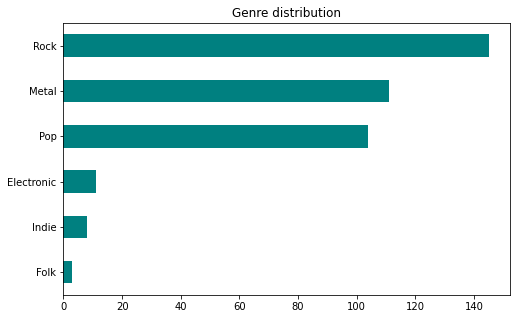

In [13]:
plt.rcParams['figure.figsize'] = [8,5]
x = de_train['Genre'].value_counts().sort_values(ascending = True)
plt.title("Genre distribution")
x.plot(kind ='barh', color="teal")

#Tokenizing the lyrics with spacy

In [14]:
x_train = de_train['Lyrics'].tolist()
y_train = de_train['Genre'].tolist()

In [15]:
x_test = de_test['Lyrics'].tolist()
y_test = de_test['Genre'].tolist()

In [16]:
len(x_train), len(y_train), len(x_test), len(y_test)

(382, 382, 96, 96)

In [17]:
set(y_train)

{'Electronic', 'Folk', 'Indie', 'Metal', 'Pop', 'Rock'}

In [18]:
sample_idx = 80
x_train[sample_idx]

'lebst du hier und jetzt hast du eigentlich schon gemerkt dass du das beste bist was dir passiert dreh’ deinen film spiel mit besetz’ die rollen wie du willst wer dir nicht passt wird einfach ausrangiert und es ist deine zeit du baust dir deine eigene welt nimm dir den sommer lass ihn ewig sein was ist mit deinem willen warum zeigst du ihn nie tu’ was du brauchst in deine träume rein du entscheidest was passiert wer in deinem kopf regiert hör auf zu heulen es liegt in deiner hand guten tag dreh’ mal bitte die boxen auf du bist da und mein gott du siehst sehr gut aus du verschwendest zeit da du niemals was vergisst und die schuld für fehler anderen gibst sei für dich bereit sei doch einfach einmal echt sei nicht nur so wie du’s im fernsehen siehst du hast zuviel verpasst der alltag fliesst durch deine venen hast dich im spiegel lang’ nicht angesehen die tage in schwarz weiss ein stummfilm ohne sinn das ist dein leben du bist mitten drin du entscheidest was passiert wer in deinem kopf re

In [19]:
y_train[sample_idx]

'Rock'

In [20]:
import string
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords, wordnet
from nltk import word_tokenize, pos_tag
from nltk.stem.wordnet import WordNetLemmatizer

stopword_list = stopwords.words('german')
punctuations = string.punctuation

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [21]:
def spacy_tokenizer (text):
   
    doc = nlp(text)

    #lemmatizing tokens and lowering case
    lemmas = [token.lemma_.lower() for token in doc]

    #removing stopwords and punctuations
    lemmas_stop= [token for token in lemmas if token not in stopword_list and token not in punctuations]  

    lemma_bigrams = ['BI_'+p1+'_'+p2 for p1,p2 in nltk.ngrams(lemmas_stop,2)]
    lemma_trigrams = ['TRI_'+p1+'_'+p2+'_'+p3 for p1,p2,p3 in nltk.ngrams(lemmas_stop,3)] 
    
    all_tokens = list()
    all_tokens.extend(lemmas_stop)
    all_tokens.extend(lemma_bigrams)
    all_tokens.extend(lemma_trigrams)
    return all_tokens

#Token vectorization with CountVectorizer and spacy_tokenizer function above

In [22]:
vectors = CountVectorizer (analyzer = spacy_tokenizer, min_df = 5)

In [23]:
print ('fit')
vectors.fit(x_train)
print('transform')
x_train_tok = vectors.transform(x_train)
x_test_tok = vectors.transform(x_test)
print ('done')

fit
transform
done


In [24]:
with open('/content/drive/MyDrive/Progetto_TA_2022/tokenized_df/de_x_train_tok.pkl', 'wb') as outfile:
  pickle.dump(x_train_tok, outfile)
with open('/content/drive/MyDrive/Progetto_TA_2022/tokenized_df/de_x_test_tok.pkl', 'wb') as outfile:
  pickle.dump(x_test_tok, outfile)

In [25]:
with open('/content/drive/MyDrive/Progetto_TA_2022/tokenized_df/de_x_train_tok.pkl', mode = 'br') as infile:
  x_train_tok = pickle.load(infile)
with open('/content/drive/MyDrive/Progetto_TA_2022/tokenized_df/de_x_test_tok.pkl', mode = 'br') as infile:
  x_test_tok = pickle.load(infile)

In [26]:
len(vectors.vocabulary_)

902

In [27]:
vectors.vocabulary_

{'kommen': 407,
 'hand': 336,
 'rock': 582,
 'singen': 663,
 'liebe': 453,
 'lass': 428,
 'haut': 344,
 'blute': 137,
 'dürfen': 182,
 'lecken': 437,
 'schmecken': 622,
 'klein': 404,
 'gut': 329,
 'verstecken': 788,
 'halten': 335,
 'eng': 201,
 'kind': 401,
 'lieben': 454,
 'glaub': 309,
 'kampf': 393,
 'fur': 270,
 'glauben': 310,
 'schmerz': 623,
 'herzen': 357,
 'stein': 700,
 'weinst': 827,
 'nie': 519,
 'allein': 76,
 'seele': 646,
 'rein': 572,
 'traum': 741,
 'weit': 833,
 'schlaf': 616,
 'grosse': 325,
 'enden': 199,
 'oft': 536,
 'm': 467,
 'streit': 712,
 'egal': 187,
 'blut': 136,
 'gott': 318,
 'kraft': 412,
 'geben': 280,
 'heisst': 349,
 'erleben': 208,
 'leben': 435,
 'einfach': 192,
 'ab': 67,
 'moment': 484,
 'sollen': 667,
 'sterben': 703,
 'n': 500,
 'herz': 356,
 'suchen': 720,
 'stark': 687,
 'fest': 237,
 'helfen': 352,
 'ja': 386,
 'kampfen': 394,
 'ewig': 215,
 'eur': 214,
 'ganz': 277,
 'unten': 766,
 'tur': 758,
 'stolz': 709,
 'erreichen': 209,
 'schaffen':

#SVM Classification

---



---



Classification report:
              precision    recall  f1-score   support

  Electronic       1.00      0.25      0.40         4
       Indie       0.00      0.00      0.00         2
       Metal       0.86      0.81      0.83        31
         Pop       0.63      0.79      0.70        24
        Rock       0.69      0.71      0.70        35

    accuracy                           0.73        96
   macro avg       0.64      0.51      0.53        96
weighted avg       0.73      0.73      0.72        96

Confusion matrix:
[[ 1  0  0  3  0]
 [ 0  0  0  0  2]
 [ 0  0 25  2  4]
 [ 0  0  0 19  5]
 [ 0  0  4  6 25]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


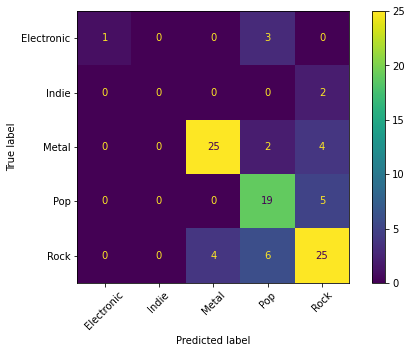

In [28]:
svm_pipeline = Pipeline([
    ('vect', CountVectorizer(min_df = 5)), #tokenization
    ('sel', SelectKBest(chi2, k='all')),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', LinearSVC())  # learning algorithm
])

svm_pipeline.fit(x_train,y_train)
predictions = svm_pipeline.predict(x_test)

print('Classification report:')
print(classification_report(y_test, predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test, predictions)
print(cm)

ConfusionMatrixDisplay.from_estimator(svm_pipeline, x_test, y_test)  
plt.xticks(rotation=45)
plt.show()

SVM classification with tokenized lyrics - no optimization

Classification report:
              precision    recall  f1-score   support

  Electronic       1.00      0.25      0.40         4
       Indie       0.00      0.00      0.00         2
       Metal       0.81      0.84      0.83        31
         Pop       0.67      0.67      0.67        24
        Rock       0.67      0.74      0.70        35

    accuracy                           0.72        96
   macro avg       0.63      0.50      0.52        96
weighted avg       0.71      0.72      0.71        96

Confusion matrix:
[[ 1  0  0  1  2]
 [ 0  0  0  0  2]
 [ 0  0 26  3  2]
 [ 0  0  1 16  7]
 [ 0  0  5  4 26]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


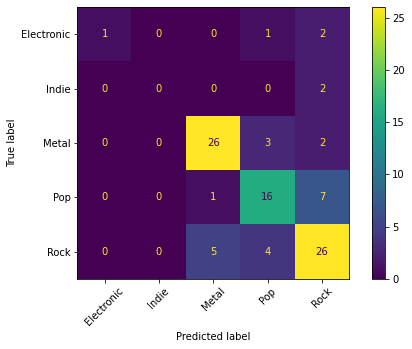

In [29]:
svm_pipeline = Pipeline([
    ('sel', SelectKBest(chi2, k='all')),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', LinearSVC())  # learning algorithm
])

svm_pipeline.fit(x_train_tok,y_train)
predictions = svm_pipeline.predict(x_test_tok)

print('Classification report:')
print(classification_report(y_test, predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test, predictions)
print(cm)

ConfusionMatrixDisplay.from_estimator(svm_pipeline, x_test_tok, y_test)  
plt.xticks(rotation=45)
plt.show()

SVM classification with tokenized lyrics and optimized parameters

In [30]:
opt_pipeline = Pipeline([
    ('sel', SelectKBest(chi2)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', LinearSVC())  # learning algorithm
])

param_grid = [{'sel__k': [50, 100, 250,'all'], 'learner__C': [0.01, 0.1, 1, 10, 100]}]
SVM_opt_search = GridSearchCV(opt_pipeline, param_grid, cv=None, n_jobs = 3, verbose=True).fit(x_train_tok,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


In [31]:
SVM_opt_search.best_params_

{'learner__C': 1, 'sel__k': 'all'}

In [32]:
SVM_opt_search.best_estimator_

Pipeline(steps=[('sel',
                 SelectKBest(k='all',
                             score_func=<function chi2 at 0x7fc42e66c7a0>)),
                ('tfidf', TfidfTransformer()), ('learner', LinearSVC(C=1))])

In [33]:
opt_predictions = SVM_opt_search.best_estimator_.predict(x_test_tok)

print('Classification report:')
print(classification_report(y_test, opt_predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test, opt_predictions)
print(cm)

Classification report:
              precision    recall  f1-score   support

  Electronic       1.00      0.25      0.40         4
       Indie       0.00      0.00      0.00         2
       Metal       0.81      0.84      0.83        31
         Pop       0.67      0.67      0.67        24
        Rock       0.67      0.74      0.70        35

    accuracy                           0.72        96
   macro avg       0.63      0.50      0.52        96
weighted avg       0.71      0.72      0.71        96

Confusion matrix:
[[ 1  0  0  1  2]
 [ 0  0  0  0  2]
 [ 0  0 26  3  2]
 [ 0  0  1 16  7]
 [ 0  0  5  4 26]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Features that weight more on classification:

In [34]:
tokenizer = vectors
selector = svm_pipeline.named_steps['sel']
classifier = svm_pipeline.named_steps['learner']

In [35]:
feature_names = tokenizer.get_feature_names_out()
feats_w_score = list()
for index,(selected,score) in enumerate(zip(selector.get_support(),selector.scores_)):
    feats_w_score.append((score,selected,feature_names[index]))
feats_w_score = sorted(feats_w_score)
len(feats_w_score)

902

In [36]:
feats_w_score[:100],feats_w_score[-100:]

([(0.49933408209270275, True, 'blei'),
  (0.49933408209270275, True, 'geschenk'),
  (0.5953547446650895, True, 'fegen'),
  (0.749001123139054, True, 'bestellen'),
  (0.7574449781346332, True, 'bezahlen'),
  (0.9740156602225569, True, 'zeile'),
  (1.0290302428233464, True, 'BI_ganz_leben'),
  (1.1527349630797907, True, 'stehn'),
  (1.1649726384209145, True, 'krank'),
  (1.190709489330179, True, 'dunkel'),
  (1.2185112433388294, True, 'unendlich'),
  (1.3158311089345573, True, 'sieben'),
  (1.3366278176623008, True, 'einsamkeit'),
  (1.3366278176623008, True, 'weisse'),
  (1.3905505839904493, True, 'stern'),
  (1.4278719783421976, True, 'lachen'),
  (1.4686720672927567, True, 'gefangen'),
  (1.5129381181105321, True, 'fassen'),
  (1.5150293245120834, True, 'such'),
  (1.530663488422109, True, 'BI_woll_n'),
  (1.530663488422109, True, 'einst'),
  (1.530663488422109, True, 'springen'),
  (1.530663488422109, True, 'woll'),
  (1.5367015339429135, True, 'the'),
  (1.592424345328157, True, 'he

In [37]:
feats_w_classifier_weight = list()
for index,weight in enumerate(selector.inverse_transform(classifier.coef_)[0]):
    if weight!=0:
        feats_w_classifier_weight.append((weight,feature_names[index]))
feats_w_classifier_weight = sorted(feats_w_classifier_weight)
len(feats_w_classifier_weight)

900

In [38]:
feats_w_classifier_weight[:100]

[(-0.33058235594704466, 'eh'),
 (-0.2668318598159946, 'sehen'),
 (-0.24800208078474936, 'wohnen'),
 (-0.24391495231607138, 'welt'),
 (-0.2308796642096316, 'gehen'),
 (-0.20243476031100247, 'nacht'),
 (-0.19098834187259192, 'name'),
 (-0.19061839262523284, 'kuss'),
 (-0.1902891175197882, 'strasse'),
 (-0.18371610923013215, 'oh'),
 (-0.17865726326231843, 'angst'),
 (-0.17413706676189575, 'do'),
 (-0.1674629318857135, 'meer'),
 (-0.16481818523155412, 'kind'),
 (-0.16163957779970925, 'gut'),
 (-0.16116915607932455, 'heuen'),
 (-0.1601672567204723, 'mehr'),
 (-0.15926654238053187, 'yeah'),
 (-0.15895374703352402, 'ort'),
 (-0.1574147359648582, 'ende'),
 (-0.14658081118078373, 'rot'),
 (-0.1462243050708086, 'seh'),
 (-0.14431291381014463, 'dürfen'),
 (-0.14322627150543882, 're'),
 (-0.1397407871342315, 'BI_gehen_gut'),
 (-0.1376032285907531, 'zeit'),
 (-0.13586300365753734, 'erst'),
 (-0.13548541357246932, 'i'),
 (-0.1338584171325118, 'egal'),
 (-0.1330517614530868, 'gleich'),
 (-0.131574255

#Naïve Bayes Classification

---



---



In [39]:
NBC_pipeline = Pipeline([
    ('sel', SelectKBest(chi2, k='all')),  # feature selection
    ('learner', MultinomialNB())  # learning algorithm
])

NBC_pipeline.fit(x_train_tok,y_train)
predictions = NBC_pipeline.predict(x_test_tok)

print('Classification report:')
print(classification_report(y_test, predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test, predictions)
print(cm)

Classification report:
              precision    recall  f1-score   support

  Electronic       0.43      0.75      0.55         4
        Folk       0.00      0.00      0.00         0
       Indie       0.00      0.00      0.00         2
       Metal       0.81      0.68      0.74        31
         Pop       0.65      0.62      0.64        24
        Rock       0.71      0.69      0.70        35

    accuracy                           0.66        96
   macro avg       0.43      0.46      0.44        96
weighted avg       0.70      0.66      0.67        96

Confusion matrix:
[[ 3  0  0  0  0  1]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  2]
 [ 3  0  0 21  3  4]
 [ 0  2  4  0 15  3]
 [ 1  0  0  5  5 24]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#Decision Tree Classification

---



---



In [40]:
dt_pipeline = Pipeline([
    ('sel', SelectKBest(chi2, k='all')),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', DecisionTreeClassifier())  # learning algorithm
])

dt_pipeline.fit(x_train_tok,y_train)
predictions = dt_pipeline.predict(x_test_tok)

print('Classification report:')
print(classification_report(y_test, predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test, predictions)
print(cm)

Classification report:
              precision    recall  f1-score   support

  Electronic       1.00      0.75      0.86         4
       Indie       0.00      0.00      0.00         2
       Metal       0.63      0.55      0.59        31
         Pop       0.62      0.62      0.62        24
        Rock       0.63      0.69      0.66        35

    accuracy                           0.61        96
   macro avg       0.58      0.52      0.55        96
weighted avg       0.63      0.61      0.62        96

Confusion matrix:
[[ 3  0  0  0  1]
 [ 0  0  0  0  2]
 [ 0  0 17  7  7]
 [ 0  0  5 15  4]
 [ 0  4  5  2 24]]


#Random Forest Classification

---






In [41]:
RF_pipeline = Pipeline([
    ('sel', SelectKBest(chi2, k='all')),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', RandomForestClassifier())  # learning algorithm
])

RF_pipeline.fit(x_train_tok,y_train)
predictions = RF_pipeline.predict(x_test_tok)

print('Classification report:')
print(classification_report(y_test, predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test, predictions)
print(cm)

Classification report:
              precision    recall  f1-score   support

  Electronic       0.00      0.00      0.00         4
       Indie       0.00      0.00      0.00         2
       Metal       0.86      0.77      0.81        31
         Pop       0.75      0.62      0.68        24
        Rock       0.62      0.86      0.72        35

    accuracy                           0.72        96
   macro avg       0.45      0.45      0.44        96
weighted avg       0.69      0.72      0.70        96

Confusion matrix:
[[ 0  0  0  2  2]
 [ 0  0  0  0  2]
 [ 0  0 24  2  5]
 [ 0  0  0 15  9]
 [ 0  0  4  1 30]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#LSTM Classification 

---





In [42]:
de_train['Genre_number'] = de_train['Genre'] #converting the strings into int in the Genre column

numbers = []
for i in de_train['Genre']:
  if i == 'Rock':
    numbers.append(0)
  
  if i == 'Pop':
    numbers.append(1)
   
  if i == 'Metal':
    numbers.append(2)

  if i == 'Folk':
   numbers.append(3)
  
  if i == 'Indie':
   numbers.append(4)

  elif i == 'Electronic':
    numbers.append(5)

In [43]:
de_train['Genre_number'] = numbers

In [44]:
de_test['Genre_number'] = de_test['Genre'] #converting the strings into int in the Genre column

numbers_test = []
for i in de_test['Genre']:
  if i == 'Rock':
    numbers_test.append(0)
  
  if i == 'Pop':
    numbers_test.append(1)
   
  if i == 'Metal':
    numbers_test.append(2)

  if i == 'Folk':
   numbers_test.append(3)
  
  if i == 'Indie':
   numbers_test.append(4)
  
  elif i == 'Electronic':
    numbers_test.append(5)
  

In [45]:
de_test['Genre_number'] = numbers_test

In [46]:
de_train.sample(5)

,Artist,Song,Genre,Language,Lyrics,Genre_number
213,tarja turunen,o tannenbaum,Metal,de,o tannenbaum o tannenbaum wie grün sind deine ...,2
204,revolverheld,wenn du sagst,Rock,de,es kommt mir vor als wärst du niemals zu mir e...,0
458,bilderbuch,ich hab gefuhle,Pop,de,woo ja di bi di ba bo yeah uh ja hah he ich bi...,1
31,rammstein,haifisch,Metal,de,wir halten zusammen wir halten einander aus wi...,2
246,tokio hotel,ich brech' aus,Rock,de,ich hab heut an anderen plan und der geht dich...,0


In [47]:
de_test.sample(5)

,Artist,Song,Genre,Language,Lyrics,Genre_number
224,tokio hotel,unendlichkeit,Rock,de,die wärme trägt uns bis in die unendlichkeit a...,0
114,rammstein,stein um stein,Metal,de,ich habe pläne grosse pläne ich baue dir ein h...,2
230,tokio hotel,beichte,Rock,de,es beginnt jeden morgen es klingelt um sieben ...,0
39,rammstein,amerika,Metal,de,we re all living in amerika amerika ist wunder...,2
12,linkin park,broken foot (meteora demo),Metal,de,instrumental linkin park underground,2


In [48]:
y_train = de_train['Genre_number'] #substituting the columns in the variables
y_test = de_test['Genre_number']

In [49]:
y_train = to_categorical(y_train,6)  #converting to one-hot vectors
y_test = to_categorical(y_test, 6)

In [50]:
y_train.shape, y_test.shape

((382, 6), (96, 6))

In [51]:
#max number of words to be used
max_features = 20000
#max number of words in each lyrics
maxlen = 200
#fixed size
embed_size = 128

batch_size = 64
epochs = 20

tokenizer = Tokenizer(num_words=max_features, lower=True)
tokenizer.fit_on_texts(list(x_train))
list_tokenized_train = tokenizer.texts_to_sequences(x_train)
list_tokenized_test = tokenizer.texts_to_sequences(x_test)

X_train_final = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_test_final = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [52]:
X_train_final.shape, y_train.shape

((382, 200), (382, 6))

In [53]:
X_test_final.shape, y_test.shape

((96, 200), (96, 6))

In [54]:
model = Sequential()
model.add(Embedding(max_features, embed_size))
model.add(LSTM(10, dropout=0.4, recurrent_dropout=0.4))
model.add(Dropout(0.4))
model.add(Dense(24, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(6, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer= SGD(learning_rate=0.01, momentum=0.8), metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         2560000   
                                                                 
 lstm (LSTM)                 (None, 10)                5560      
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense (Dense)               (None, 24)                264       
                                                                 
 dropout_1 (Dropout)         (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 150       
                                                                 
Total params: 2,565,974
Trainable params: 2,565,974
Non-

In [55]:
lstm = model.fit(X_train_final, y_train,
                 batch_size=batch_size, 
                 epochs=epochs, 
                 shuffle = True, 
                 validation_split=0.2, 
                 callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
lstm

Epoch 1/20
5/5 [==============================] - 4s 284ms/step - loss: 1.7830 - accuracy: 0.2098 - val_loss: 1.7624 - val_accuracy: 0.3506
Epoch 2/20
5/5 [==============================] - 1s 270ms/step - loss: 1.7405 - accuracy: 0.3770 - val_loss: 1.7094 - val_accuracy: 0.3506
Epoch 3/20
5/5 [==============================] - 2s 331ms/step - loss: 1.6932 - accuracy: 0.3574 - val_loss: 1.6548 - val_accuracy: 0.3506
Epoch 4/20
5/5 [==============================] - 1s 223ms/step - loss: 1.6359 - accuracy: 0.3279 - val_loss: 1.6062 - val_accuracy: 0.3506
Epoch 5/20
5/5 [==============================] - 1s 198ms/step - loss: 1.6001 - accuracy: 0.3672 - val_loss: 1.5654 - val_accuracy: 0.3506
Epoch 6/20
5/5 [==============================] - 1s 203ms/step - loss: 1.5495 - accuracy: 0.3738 - val_loss: 1.5297 - val_accuracy: 0.3506
Epoch 7/20
5/5 [==============================] - 1s 195ms/step - loss: 1.5310 - accuracy: 0.3574 - val_loss: 1.4999 - val_accuracy: 0.3506
Epoch 8/20
5/5 [====

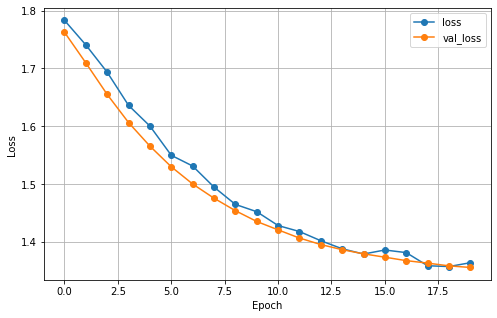

In [56]:
plt.plot(lstm.history['loss'], label='loss', marker = 'o')
plt.plot(lstm.history['val_loss'], label = 'val_loss', marker = 'o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend(loc='upper right')

Testing LSTM Classification

In [57]:
lstm_pred= np.round(model.predict(X_test_final))

3/3 [==============================] - 0s 18ms/step


In [58]:
print('Accuracy %s' % accuracy_score(y_test, lstm_pred))
print('F1-score %s' % f1_score(y_test, lstm_pred, average=None))
print('Classification report:')
print(classification_report(y_test, lstm_pred))

Accuracy 0.0
F1-score [0. 0. 0. 0. 0. 0.]
Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        35
           1       0.00      0.00      0.00        24
           2       0.00      0.00      0.00        31
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         4

   micro avg       0.00      0.00      0.00        96
   macro avg       0.00      0.00      0.00        96
weighted avg       0.00      0.00      0.00        96
 samples avg       0.00      0.00      0.00        96



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classifi

#CNN Classification

In [59]:
#max number of words to be used
max_features = 20000
#max number of words in each lyrics
maxlen = 200
#fixed size
embed_size = 128

batch_size = 64
epochs = 20
filters = 10
kernel_size = 3
hidden_dims = 10

tokenizer = Tokenizer(num_words=max_features, lower=True)
tokenizer.fit_on_texts(list(x_train))
list_tokenized_train = tokenizer.texts_to_sequences(x_train)
list_tokenized_test = tokenizer.texts_to_sequences(x_test)

X_train_final = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_test_final = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [60]:
X_train_final[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 3794,
         20,   10, 3795, 3796, 1718, 2652,    3, 1507,   41,   98, 2653,
       2654,  349, 3797,   13,   10,  130,  245, 2655,   76,  238,    2,
         52,   68, 2081, 3798,  320,  220,    2, 3799,   76,   39,   24,
       2656,   39,   24, 3800,    2,   10, 3801,   50, 1081,  452,   82,
       1507,   65,    3, 1718,    1,   39,   38,  173,  202,  983,  144,
        769, 2082,    6,    3, 2083,   42,    4, 1719,    5,   15,   12,
         10, 2653,  197,  144, 2081, 3802, 1205,    2,   24,   50,   85,
       3803, 2657,   56, 1720, 3804, 3805, 3806,   24,   83, 3807,   13,
         10, 3808,   91, 1206,  100,   76,    3, 1507, 3809,  542,   74,
         83, 3810,   24,  770, 2084,    2,  100,   

In [61]:
model = Sequential()

model.add(Embedding(max_features, embed_size))
model.add(Dropout(0.4))
model.add(Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1))
model.add(GlobalMaxPooling1D())

#vanilla dense layer
model.add(Dense(15))
model.add(Dropout(0.4))
model.add(Activation('relu'))

#output layer
model.add(Dense(6))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         2560000   
                                                                 
 dropout_2 (Dropout)         (None, None, 128)         0         
                                                                 
 conv1d (Conv1D)             (None, None, 10)          3850      
                                                                 
 global_max_pooling1d (Globa  (None, 10)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 15)                165       
                                                                 
 dropout_3 (Dropout)         (None, 15)                0         
                                                      

In [62]:
cnn= model.fit(X_train_final, y_train, 
          batch_size = batch_size, 
          epochs=30, 
          shuffle=True, 
          validation_split=0.1,
          callbacks= [EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/30
6/6 [==============================] - 1s 110ms/step - loss: 1.8930 - accuracy: 0.0204 - val_loss: 1.8356 - val_accuracy: 0.0256
Epoch 2/30
6/6 [==============================] - 0s 75ms/step - loss: 1.8459 - accuracy: 0.0321 - val_loss: 1.8032 - val_accuracy: 0.0256
Epoch 3/30
6/6 [==============================] - 0s 70ms/step - loss: 1.8038 - accuracy: 0.0554 - val_loss: 1.7796 - val_accuracy: 0.0256
Epoch 4/30
6/6 [==============================] - 0s 67ms/step - loss: 1.7689 - accuracy: 0.1137 - val_loss: 1.7645 - val_accuracy: 0.0256
Epoch 5/30
6/6 [==============================] - 0s 67ms/step - loss: 1.7599 - accuracy: 0.1429 - val_loss: 1.7513 - val_accuracy: 0.0256
Epoch 6/30
6/6 [==============================] - 0s 72ms/step - loss: 1.7296 - accuracy: 0.2099 - val_loss: 1.7381 - val_accuracy: 0.1795
Epoch 7/30
6/6 [==============================] - 0s 69ms/step - loss: 1.7101 - accuracy: 0.2566 - val_loss: 1.7240 - val_accuracy: 0.3077
Epoch 8/30
6/6 [==========

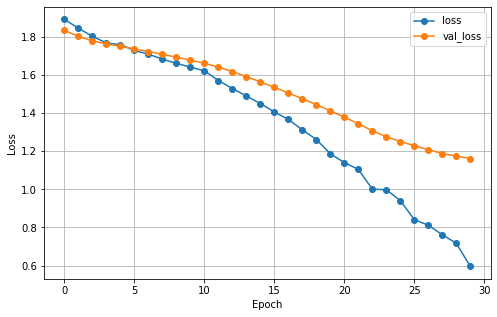

In [63]:
plt.plot(cnn.history['loss'], label='loss', marker = 'o')
plt.plot(cnn.history['val_loss'], label = 'val_loss', marker = 'o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend(loc='upper right')

Testing CNN Classification

In [64]:
cnn_pred= np.round(model.predict(X_test_final))

3/3 [==============================] - 0s 6ms/step


In [65]:
print('Accuracy %s' % accuracy_score(y_test, cnn_pred))
print('F1-score %s' % f1_score(y_test, cnn_pred, average=None))
print('Classification report:')
print(classification_report(y_test, cnn_pred))

Accuracy 0.3125
F1-score [0.60869565 0.         0.45       0.         0.         0.        ]
Classification report:
              precision    recall  f1-score   support

           0       0.62      0.60      0.61        35
           1       0.00      0.00      0.00        24
           2       1.00      0.29      0.45        31
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         4

   micro avg       0.68      0.31      0.43        96
   macro avg       0.27      0.15      0.18        96
weighted avg       0.55      0.31      0.37        96
 samples avg       0.31      0.31      0.31        96



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classifi

#Classification with Word2Vec

In [66]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [67]:
pip install --upgrade gensim


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 1.4 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [68]:
import gensim
from gensim.models import Word2Vec

In [69]:
df_de['Genre_number'] = df_de['Genre'] #converting the strings into int in the Genre column

numbers = []
for i in df_de['Genre']:
  if i == 'Rock':
    numbers.append(0)
  
  if i == 'Pop':
    numbers.append(1)
   
  if i == 'Metal':
    numbers.append(2)

  if i == 'Folk':
   numbers.append(3)
  
  if i == 'Indie':
   numbers.append(4)
  
  elif i == 'Electronic':
    numbers.append(5)

In [70]:
df_de['Genre_number'] = numbers

In [71]:
#Gensim word2vec requires sentences in input so i split the lyrics into sentences
sentence_splitter = nltk.data.load('tokenizers/punkt/german.pickle')
sentences =[]
sum=0
for lyrics in df_de['Lyrics']:
  sents = sentence_splitter.tokenize(lyrics.strip())
  sum+=len(sents)
  for sent in sents:
    sentences.append(sent.split())
print(sum)
print(len(sentences))

478
478


In [72]:
#checking that the sentences are in the correct format
for sent in sentences[:5]:
  print(sent, "\n")

['der', 'vorhang', 'ist', 'gefallen', 'es', 'gibt', 'keinen', 'weg', 'zurück', 'das', 'lebenselixier', 'ist', 'versiegt', 'diese', 'verdorbenen', 'worte', 'wurden', 'gemacht', 'um', 'zu', 'verletzen', 'schneiden', 'mich', 'mit', 'ihrem', 'messer', 'fressen', 'meine', 'gedanken', 'und', 'mit', 'jedem', 'biss', 'bettle', 'ich', 'bitte', 'herr', 'nicht', 'dieser', 'ort', 'ist', 'ein', 'chaos', 'die', 'eine', 'ist', 'gegangen', 'liebeslieder', 'bringen', 'mich', 'um', 'bringen', 'mich', 'um', 'jetzt', 'liebeslieder', 'bringen', 'mich', 'um', 'sie', 'töten', 'mich', 'genau', 'jetzt', 'geübt', 'darin', 'anzugreifen', 'immer', 'direkt', 'ins', 'schwarze', 'zu', 'treffen', 'ich', 'hätte', 'nie', 'gedacht', 'dass', 'sie', 'mich', 'erwischen', 'diese', 'bilder', 'in', 'meinem', 'kopf', 'nun', 'liege', 'ich', 'im', 'bett', 'diese', 'peitschenschläge', 'lassen', 'mich', 'bluten', 'bei', 'mir', 'herrscht', 'chaos', 'meine', 'eine', 'ist', 'gegangen', 'liebeslieder', 'bringen', 'mich', 'um', 'bringe

In [73]:
#creating the w2v embeddings
w2v_model=gensim.models.Word2Vec(sentences=sentences, vector_size=300, window=10, min_count=1)

In [74]:
w2v_model.train(sentences, epochs=10, total_examples=len(sentences))

(819945, 1065930)

In [75]:
#total num of extracted words
vocab = w2v_model.wv.index_to_key
print("Total number of words: ", len(vocab))

Total number of words:  8226


In [76]:
w2v_model.wv.most_similar('fräulein')

[('zähne', 0.9347200393676758),
 ('weidmanns', 0.9345476627349854),
 ('manns', 0.9297246932983398),
 ('mütter', 0.9275733232498169),
 ('abgebaut', 0.9260640740394592),
 ('glitzerstrahl', 0.9218477606773376),
 ('weggerannt', 0.9183561205863953),
 ('observiert', 0.9183006882667542),
 ('sonntagmorgen', 0.9140361547470093),
 ('mekka', 0.9126649498939514)]

In [77]:
#creating a dictionary with words in vocab and their embeddings. It will be used to create the embedding matrix 

word_vec_dict={}

for word in vocab:
  word_vec_dict[word]=w2v_model.wv.get_vector(word)

len(word_vec_dict)

8226

In [78]:
#finding the max length of the lyrics
maxi = -1
for i, lyrics in enumerate(df_de['Lyrics']):
  tokens=lyrics.split()
  if(len(tokens)>maxi):
    maxi=len(tokens)

print(maxi)

1778


In [79]:
#integer encoding the words in the lyrics using Keras Tokenizer
tok=Tokenizer()
tok.fit_on_texts(df_de['Lyrics'])
vocab_size = len(tok.word_index) +1
encoded_lyrics = tok.texts_to_sequences(df_de['Lyrics'])

In [80]:
max_lyrics_len=maxi
embed_dim = 300

#padding every sequence to the max length
padded_lyrics=pad_sequences(encoded_lyrics, maxlen=max_lyrics_len, padding='post')
padded_lyrics.shape

(478, 1778)

In [81]:
#creating the embedding matrix
embed_matrix = np.zeros(shape=(vocab_size, embed_dim))
for word, i in tok.word_index.items():
  embed_vector=word_vec_dict.get(word)
  if embed_vector is not None: #if the word is in the vocabulary learned by the w2v model
    embed_matrix[i]=embed_vector
    #if the word is not found, the vector corresponding to the embedding will be filled with zeros

In [82]:
Y= to_categorical(df_de['Genre_number'], 6) #transforming the labels into one hot vectors
x_train,x_test,y_train,y_test=train_test_split(padded_lyrics, Y,test_size=0.20,random_state=42)

In [83]:
y_train.shape, y_test.shape

((382, 6), (96, 6))

#LSTM Classification with Word2Vec

---



---



In [84]:
from keras.initializers import Constant

In [85]:
epochs=20
batch_size=64

In [86]:
model=Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_lyrics_len, trainable=False, embeddings_initializer=Constant(embed_matrix)))
model.add(LSTM(5, dropout=0.4, recurrent_dropout=0.4))
model.add(Dropout(0.4))
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1778, 300)         2465400   
                                                                 
 lstm_1 (LSTM)               (None, 5)                 6120      
                                                                 
 dropout_4 (Dropout)         (None, 5)                 0         
                                                                 
 dense_4 (Dense)             (None, 10)                60        
                                                                 
 dropout_5 (Dropout)         (None, 10)                0         
                                                                 
 dense_5 (Dense)             (None, 6)                 66        
                                                                 
Total params: 2,471,646
Trainable params: 6,246
Non-tr

In [87]:
lstm_w2v = model.fit(x_train,
                     y_train,
                     epochs=epochs,
                     batch_size=batch_size,
                     shuffle = True, 
                     validation_split=0.2, 
                     callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/20
5/5 [==============================] - 27s 5s/step - loss: 1.7900 - accuracy: 0.3377 - val_loss: 1.7866 - val_accuracy: 0.3636
Epoch 2/20
5/5 [==============================] - 14s 2s/step - loss: 1.7832 - accuracy: 0.3705 - val_loss: 1.7780 - val_accuracy: 0.3636
Epoch 3/20
5/5 [==============================] - 12s 2s/step - loss: 1.7736 - accuracy: 0.3672 - val_loss: 1.7684 - val_accuracy: 0.3636
Epoch 4/20
5/5 [==============================] - 12s 2s/step - loss: 1.7631 - accuracy: 0.3836 - val_loss: 1.7579 - val_accuracy: 0.3636
Epoch 5/20
5/5 [==============================] - 12s 2s/step - loss: 1.7501 - accuracy: 0.3967 - val_loss: 1.7466 - val_accuracy: 0.3636
Epoch 6/20
5/5 [==============================] - 12s 2s/step - loss: 1.7401 - accuracy: 0.3672 - val_loss: 1.7346 - val_accuracy: 0.3636
Epoch 7/20
5/5 [==============================] - 12s 2s/step - loss: 1.7264 - accuracy: 0.3443 - val_loss: 1.7219 - val_accuracy: 0.3636
Epoch 8/20
5/5 [==================

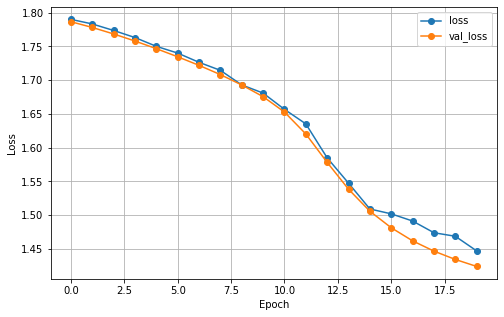

In [88]:
plt.plot(lstm_w2v.history['loss'], label='loss', marker = 'o')
plt.plot(lstm_w2v.history['val_loss'], label = 'val_loss', marker = 'o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend(loc='upper right')

Testing LSTM classification with w2v

In [89]:
lstmW2V_pred = np.round(model.predict(x_test))

3/3 [==============================] - 1s 175ms/step


In [90]:
print('Accuracy %s' % accuracy_score(y_test, lstmW2V_pred))
print('F1-score %s' % f1_score(y_test, lstmW2V_pred, average=None))
print('Classification report:')
print(classification_report(y_test, lstmW2V_pred))

Accuracy 0.0
F1-score [0. 0. 0. 0. 0. 0.]
Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        32
           1       0.00      0.00      0.00        28
           2       0.00      0.00      0.00        33
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         2

   micro avg       0.00      0.00      0.00        96
   macro avg       0.00      0.00      0.00        96
weighted avg       0.00      0.00      0.00        96
 samples avg       0.00      0.00      0.00        96



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classifi

#CNN Classification with Word2Vec

In [91]:
filters=10
kernel_size=3
epochs=20

In [92]:
model=Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_lyrics_len, trainable=False, embeddings_initializer=Constant(embed_matrix)))
model.add(Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.4))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.01, momentum=0.8), metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 1778, 300)         2465400   
                                                                 
 conv1d_1 (Conv1D)           (None, 1776, 10)          9010      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 10)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_6 (Dropout)         (None, 10)                0         
                                                                 
 dense_6 (Dense)             (None, 32)                352       
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                      

In [93]:
cnn_w2v = model.fit(x_train,
                     y_train,
                     epochs=epochs,
                     batch_size=batch_size,
                     shuffle = True, 
                     validation_split=0.2, 
                     callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
cnn_w2v

Epoch 1/20
5/5 [==============================] - 2s 386ms/step - loss: 2.5175 - accuracy: 0.1902 - val_loss: 1.6833 - val_accuracy: 0.2468
Epoch 2/20
5/5 [==============================] - 2s 341ms/step - loss: 1.6858 - accuracy: 0.3082 - val_loss: 1.5537 - val_accuracy: 0.3636
Epoch 3/20
5/5 [==============================] - 2s 345ms/step - loss: 1.5288 - accuracy: 0.3639 - val_loss: 1.4511 - val_accuracy: 0.3636
Epoch 4/20
5/5 [==============================] - 2s 353ms/step - loss: 1.4550 - accuracy: 0.4328 - val_loss: 1.3859 - val_accuracy: 0.3896
Epoch 5/20
5/5 [==============================] - 2s 356ms/step - loss: 1.4719 - accuracy: 0.3770 - val_loss: 1.3633 - val_accuracy: 0.3766
Epoch 6/20
5/5 [==============================] - 2s 347ms/step - loss: 1.4249 - accuracy: 0.3770 - val_loss: 1.3720 - val_accuracy: 0.3506
Epoch 7/20
5/5 [==============================] - 2s 342ms/step - loss: 1.4119 - accuracy: 0.3705 - val_loss: 1.3666 - val_accuracy: 0.3636
Epoch 8/20
5/5 [====

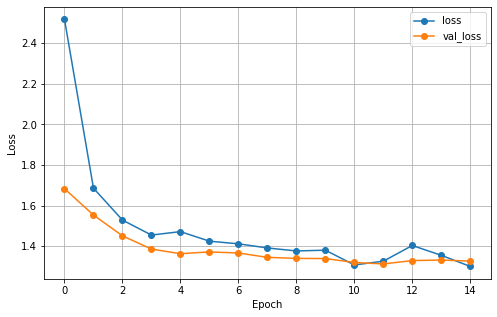

In [94]:
plt.plot(cnn_w2v.history['loss'], label='loss', marker = 'o')
plt.plot(cnn_w2v.history['val_loss'], label = 'val_loss', marker = 'o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend(loc='upper right')

Testing CNN classification with w2v

In [95]:
cnnW2V_pred = np.round(model.predict(x_test))

3/3 [==============================] - 0s 59ms/step


In [96]:
print('Accuracy %s' % accuracy_score(y_test, cnnW2V_pred))
print('F1-score %s' % f1_score(y_test, cnnW2V_pred, average=None))
print('Classification report:')
print(classification_report(y_test, cnnW2V_pred, zero_division=1))

Accuracy 0.03125
F1-score [0.15789474 0.         0.         0.         0.         0.        ]
Classification report:
              precision    recall  f1-score   support

           0       0.50      0.09      0.16        32
           1       1.00      0.00      0.00        28
           2       1.00      0.00      0.00        33
           3       1.00      1.00      1.00         0
           4       1.00      0.00      0.00         1
           5       1.00      0.00      0.00         2

   micro avg       0.50      0.03      0.06        96
   macro avg       0.92      0.18      0.19        96
weighted avg       0.83      0.03      0.05        96
 samples avg       0.97      0.03      0.03        96



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
